# Lab l Cross Validation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

### Step 0 l Data preparation

In [2]:
churnData = pd.read_csv('./files_for_lab/Customer-Churn.csv')
churnData.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


In [3]:
churnData.columns = [column.lower().replace(' ', '_').replace('#_','') for column in churnData.columns]

In [4]:
churnData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   onlinesecurity    7043 non-null   object 
 7   onlinebackup      7043 non-null   object 
 8   deviceprotection  7043 non-null   object 
 9   techsupport       7043 non-null   object 
 10  streamingtv       7043 non-null   object 
 11  streamingmovies   7043 non-null   object 
 12  contract          7043 non-null   object 
 13  monthlycharges    7043 non-null   float64
 14  totalcharges      7043 non-null   object 
 15  churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

In [5]:
churnData['totalcharges'] = pd.to_numeric(churnData['totalcharges'], errors='coerce')

In [6]:
churnData.isnull().sum()

gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [7]:
churnData['totalcharges'].fillna((churnData['totalcharges'].mean()), inplace=True)

In [8]:
X = churnData[['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges']]
y = churnData['churn']

In [9]:
transformer = Normalizer() 
transformer.fit(X)
x_normalized = transformer.transform(X)
x_normalized.shape

(7043, 4)

### Step 1 l SMOTE for upsampling

In [10]:
smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

No     5174
Yes    5174
Name: churn, dtype: int64

- Use logistic regression to fit the model and compute the accuracy of the model.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=100)

In [12]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression()

In [13]:
reg_score = logreg.score(X_test, y_test)

- Use decision tree classifier to fit the model and compute the accuracy of the model.

In [14]:
X, y = load_iris(return_X_y=True)
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
tree_score = model.score(X_test, y_test)

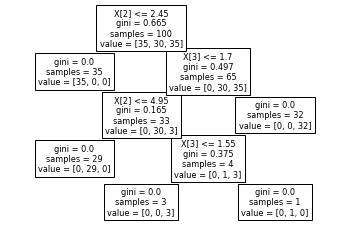

In [16]:
tree.plot_tree(model);

- Compare the accuracies of the two models.

In [17]:
print('Logistic regression: ', round(reg_score,2))

print('Decission tree: ', tree_score)

Logistic regression:  0.74
Decission tree:  0.94


### Step 2 l Tomek Links for downsampling

- Use logistic regression to fit the model and compute the accuracy of the model.

In [18]:
X = churnData[['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges']]
y = churnData['churn']

In [19]:
transformer = Normalizer() 
transformer.fit(X)
x_normalized = transformer.transform(X)
x_normalized.shape

(7043, 4)

In [20]:
tomek = TomekLinks()
X_tl, y_tl = tomek.fit_resample(X, y)
y_tl.value_counts()

No     4620
Yes    1869
Name: churn, dtype: int64

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.2, random_state=100)

In [22]:
model = LogisticRegression()

In [23]:
logreg.fit(X_tl, y_tl)
T_reg_score = logreg.score(X_test, y_test)

- Use decision tree classifier to fit the model and compute the accuracy of the model.

In [24]:
X, y = load_iris(return_X_y=True)
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.33)

In [26]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
T_tree_score = model.score(X_test, y_test)

- Compare the accuracies of the two models.

In [27]:
print('Logistic regression: ', round(T_reg_score,2))

print('Decission tree: ', round(T_tree_score,2))

Logistic regression:  0.8
Decission tree:  0.75


- Apply the algorithm one more time and check the how the imbalance in the two classes changed from the last time.